In [104]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
df = pd.read_excel('7050_data.xlsx')

# ---------------------------------------------------------------------------------------------------------------

# Data exploration

In [106]:
df.head()

,Site number,Patient number,Patient id in former eCRF,Date of consent,Inclusion criteria,First name,Last name,Gender,Birth date,Patient code in the center,Date of referral in the center,Height,Weight,Date of creation of patient,Did the patient have pre-colectomy therapy (radiotherapy excluded),Specify,Did the patient have pre-colectomy radiotherapy,Laparoscopic resection,Date of first colectomy,Tumor,Node,Metastasis,Number of resected lymph nodes,Number of resected lymph nodes.1,Number of metastatic lymph nodes,Number of metastatic lymph nodes.1,Tumor margin (rectal tumor only),EGFR amplification,Other mutation,Which,Microsatellite,Diagnosis date,Synchronicity of colorectal cancer,Number of hepatic metastases,Number of hepatic metastases.1,Hepatic metastases maximum size (mm),Hepatic metastases maximum size,Localization,Side,KRAS mutation,Which.1,Microsatellite.1,CT scan abdominal,CT scan chest,MRI,Pet CT,Scintigraphy,Initial resectability,Specify.1,Main reason,ECOG PS at Metastatic diagnosis,Leucocytes,Lower normal range,Higher normal range,Hemoglobin,Lower normal range.1,Higher normal range,Platelets,Lower normal range.2,Higher normal range.1,CEA,Lower normal range.3,Higher normal range.2,Alkaline phosphatases,Lower normal range.4,Higher normal range.3,LDH,Lower normal range.5,Higher normal range.4,Albumin,Lower normal range.6,Higher normal range.5,CA19.9,Lower normal range.7,Higher normal range.6,Does the patient have concomitant extra-hepatic metastases,Diagnosis date.1,CEA (car-old),PATIENT_STATUS
0,95,176,176.0,NaT,Yes,XXX,XXX,Male,NaT,176,2008-07-04,NaN,NaN,2018-06-15,No,NaN,No,No,NaT,T3,N0,M0,ND,ND,0,0,NaN,NaN,NaN,NaN,NaN,2008-06-13,No,1,1,56,56,Unilateral,NaN,NaN,NaN,NaN,Yes,Yes,No,No,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaT,87.9,Deceased
1,95,331,331.0,NaT,Yes,XXX,XXX,Female,NaT,331,2010-02-26,NaN,NaN,2018-06-15,No,NaN,No,No,NaT,T3,N1,M1,ND,ND,ND,ND,NaN,NaN,NaN,NaN,NaN,NaT,Yes,1,1,30,30,Unilateral,NaN,NaN,NaN,NaN,Yes,Yes,Yes,No,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaT,ND,Deceased
2,95,800,800.0,NaT,Yes,XXX,XXX,Male,NaT,800,2012-01-27,NaN,NaN,2018-06-15,Yes,NaN,No,ND,NaT,ND,ND,ND,ND,ND,ND,ND,NaN,NaN,NaN,NaN,NaN,2011-08-23,Yes,ND,ND,ND,ND,Bilateral,NaN,NaN,NaN,NaN,Yes,Yes,Yes,No,NaN,No,NaN,Number of metastasis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,ND,Alive
3,95,347,347.0,NaT,Yes,XXX,XXX,Male,NaT,347,2010-02-19,NaN,NaN,2018-06-15,Yes,NaN,Yes,ND,NaT,ND,ND,ND,ND,ND,ND,ND,NaN,NaN,NaN,NaN,NaN,NaT,Yes,3,3,ND,ND,Bilateral,NaN,NaN,NaN,NaN,Yes,Yes,Yes,No,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaT,79.3,Deceased
4,95,744,744.0,NaT,Yes,XXX,XXX,Male,NaT,744,2013-02-22,NaN,NaN,2018-06-15,No,NaN,No,Yes,2012-08-14,T4,N2,M0,ND,ND,ND,ND,NaN,NaN,NaN,NaN,NaN,2012-07-18,Yes,6,6,6,6,Unilateral,NaN,NaN,NaN,NaN,Yes,Yes,Yes,No,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaT,1,Alive


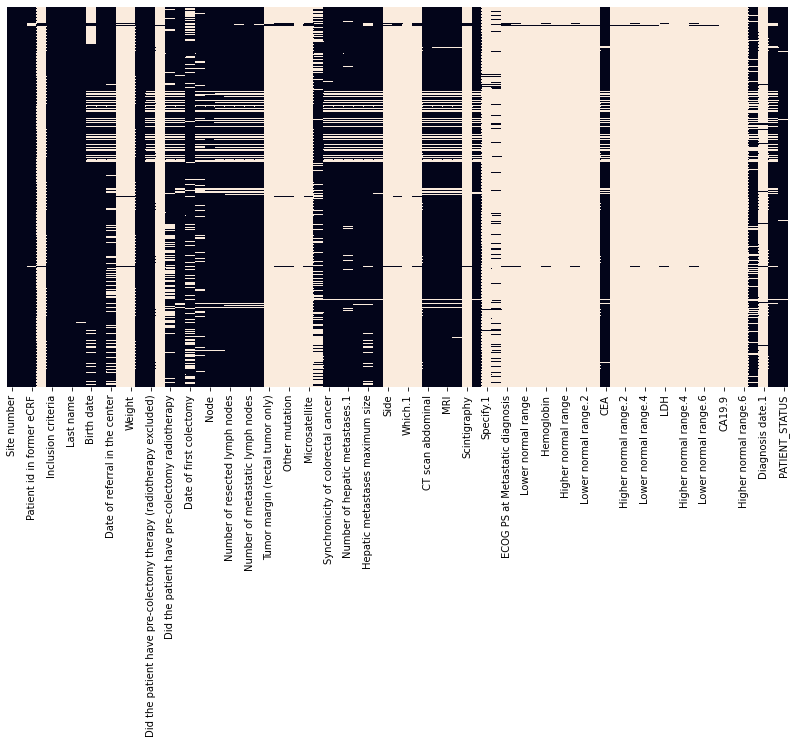

In [107]:
plt.figure(figsize = (14,7))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

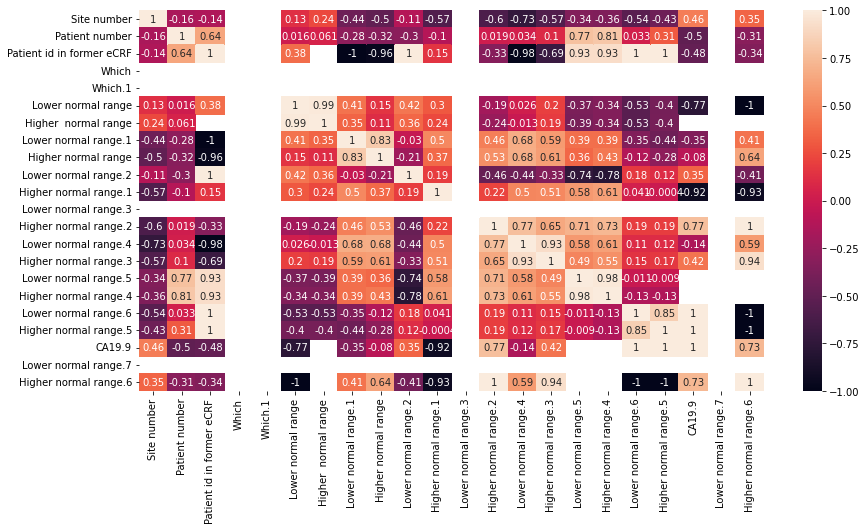

In [108]:
#To understand correlation between variables
plt.figure(figsize = (14,7))
sns.heatmap(df.corr(), annot = True)

In [109]:
'''
We notice that some columns have correlation coefficient as 1 which means either these features are highly 
co-realated or they are duplicates.We'll handle these values later down.
'''

"\nWe notice that some columns have correlation coefficient as 1 which means either these features are highly \nco-realated or they are duplicates.We'll handle these values later down.\n"

In [110]:
df.nunique().head()

Site number                    23
Patient number               1230
Patient id in former eCRF    1737
Date of consent                41
Inclusion criteria              2
dtype: int64

In [111]:
df.isna().sum().head()

Site number                     0
Patient number                  0
Patient id in former eCRF      43
Date of consent              4389
Inclusion criteria              1
dtype: int64

In [112]:
df.columns

Index(['Site number', 'Patient number', 'Patient id in former eCRF',
       'Date of consent', 'Inclusion criteria', 'First name', 'Last name',
       'Gender', 'Birth date', 'Patient code in the center',
       'Date of referral in the center', 'Height', 'Weight',
       'Date of creation of patient',
       'Did the patient have pre-colectomy therapy (radiotherapy excluded)',
       'Specify', 'Did the patient have pre-colectomy radiotherapy',
       'Laparoscopic resection', 'Date of first colectomy', 'Tumor', 'Node',
       'Metastasis', 'Number of resected lymph nodes',
       'Number of resected lymph nodes.1', 'Number of metastatic lymph nodes',
       'Number of metastatic lymph nodes.1',
       'Tumor margin (rectal tumor only)', 'EGFR amplification',
       'Other mutation', 'Which', 'Microsatellite', 'Diagnosis date',
       'Synchronicity of colorectal cancer', 'Number of hepatic metastases',
       'Number of hepatic metastases.1',
       'Hepatic metastases maximum size (

In [113]:
df.describe()

,Site number,Patient number,Patient id in former eCRF,Which,Which.1,Lower normal range,Higher normal range,Lower normal range.1,Higher normal range,Lower normal range.2,Higher normal range.1,Lower normal range.3,Higher normal range.2,Lower normal range.4,Higher normal range.3,Lower normal range.5,Higher normal range.4,Lower normal range.6,Higher normal range.5,CA19.9,Lower normal range.7,Higher normal range.6
count,4437.000000,4437.000000,4394.000000,0.0,0.0,23.000000,23.000000,24.000000,24.000000,24.000000,24.000000,21.0,21.000000,22.000000,22.000000,10.000000,10.000000,17.000000,17.000000,6.000000,6.0,6.000000
mean,85.180753,460.683570,179.724624,NaN,NaN,2540.634783,6586.826087,12.754167,16.541667,141.666667,412.083333,0.0,4.147619,31.545455,118.000000,158.700000,331.100000,6.952941,12.176471,297.950000,0.0,40.500000
std,58.155855,347.046703,385.082121,NaN,NaN,2096.091131,5397.965346,0.784624,1.020621,7.613870,36.591656,0.0,1.758869,8.279218,26.875374,113.540057,211.798358,11.192638,16.768405,394.467113,0.0,9.586449
min,5.000000,1.000000,-873.000000,NaN,NaN,3.000000,9.000000,11.000000,14.000000,130.000000,320.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.0,35.000000
25%,28.000000,152.000000,4.000000,NaN,NaN,4.000000,11.000000,12.000000,16.000000,140.000000,400.000000,0.0,3.500000,30.000000,120.000000,81.750000,242.500000,3.500000,5.200000,45.350000,0.0,37.000000
50%,95.000000,385.000000,152.000000,NaN,NaN,4000.000000,10800.000000,13.000000,17.000000,140.000000,400.000000,0.0,3.500000,30.000000,120.000000,133.000000,248.000000,3.500000,5.200000,67.900000,0.0,37.000000
75%,128.000000,738.000000,385.000000,NaN,NaN,4000.000000,11000.000000,13.000000,17.000000,150.000000,450.000000,0.0,5.000000,38.000000,126.000000,268.500000,525.500000,3.500000,5.200000,514.350000,0.0,37.000000
max,575.000000,1568.000000,1340.000000,NaN,NaN,4800.000000,11000.000000,14.000000,18.000000,150.000000,450.000000,0.0,10.000000,40.000000,136.000000,313.000000,618.000000,38.000000,52.000000,930.900000,0.0,60.000000


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 79 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   Site number                                                         4437 non-null   int64         
 1   Patient number                                                      4437 non-null   int64         
 2   Patient id in former eCRF                                           4394 non-null   float64       
 3   Date of consent                                                     48 non-null     datetime64[ns]
 4   Inclusion criteria                                                  4436 non-null   object        
 5   First name                                                          4437 non-null   object        
 6   Last name                                               

# ---------------------------------------------------------------------------------------------------------------

# Data Cleaning

### Segregating features with high null values

In [115]:
#Segregating features with null values more than 25%
features_list = []
null_list = []

for column in df.columns:
    if df[column].isna().sum() > (df.shape[0]*0.25):
        null_list.append(column)
    else:
        features_list.append(column)

### Dropping features 
* Which are irrelevant to the target variable
* Which has more than 25% missing values
* Duplicate columns

In [116]:
#Removing missing values
df.drop(null_list, axis = 1, inplace = True)

In [117]:
#To view duplicate columns side by side
df[['Hepatic metastases maximum size','Hepatic metastases maximum size (mm)',
    'CEA (car-old)','CEA',
    'Number of hepatic metastases.1','Number of hepatic metastases',
    'Number of resected lymph nodes.1','Number of resected lymph nodes',
    'Number of metastatic lymph nodes.1','Number of metastatic lymph nodes',
    ]].head(20)


'''
Hepatic metastases maximum size', CEA (car-old), Number of hepatic metastases.1, Number of resected lymph nodes.1
Number of metastatic lymph nodes.1 
are duplicate columns
'''

"\nHepatic metastases maximum size', CEA (car-old), Number of hepatic metastases.1, Number of resected lymph nodes.1\nNumber of metastatic lymph nodes.1 \nare duplicate columns\n"

### Removing duplicates and irrelevant features

In [118]:
df.drop(['Site number','Patient number','Patient id in former eCRF','First name','Last name',
         'Patient code in the center','Hepatic metastases maximum size','CEA (car-old)','Number of hepatic metastases.1',
         'Number of resected lymph nodes.1','Number of metastatic lymph nodes.1'], 
          axis = 1, inplace = True)



In [119]:
df.head()

,Inclusion criteria,Gender,Birth date,Date of referral in the center,Date of creation of patient,Did the patient have pre-colectomy therapy (radiotherapy excluded),Did the patient have pre-colectomy radiotherapy,Laparoscopic resection,Date of first colectomy,Tumor,Node,Metastasis,Number of resected lymph nodes,Number of metastatic lymph nodes,Synchronicity of colorectal cancer,Number of hepatic metastases,Hepatic metastases maximum size (mm),Localization,CT scan abdominal,CT scan chest,MRI,Pet CT,Initial resectability,CEA,Does the patient have concomitant extra-hepatic metastases,PATIENT_STATUS
0,Yes,Male,NaT,2008-07-04,2018-06-15,No,No,No,NaT,T3,N0,M0,ND,0,No,1,56,Unilateral,Yes,Yes,No,No,Yes,87.9,No,Deceased
1,Yes,Female,NaT,2010-02-26,2018-06-15,No,No,No,NaT,T3,N1,M1,ND,ND,Yes,1,30,Unilateral,Yes,Yes,Yes,No,Yes,ND,No,Deceased
2,Yes,Male,NaT,2012-01-27,2018-06-15,Yes,No,ND,NaT,ND,ND,ND,ND,ND,Yes,ND,ND,Bilateral,Yes,Yes,Yes,No,No,ND,NaN,Alive
3,Yes,Male,NaT,2010-02-19,2018-06-15,Yes,Yes,ND,NaT,ND,ND,ND,ND,ND,Yes,3,ND,Bilateral,Yes,Yes,Yes,No,Yes,79.3,No,Deceased
4,Yes,Male,NaT,2013-02-22,2018-06-15,No,No,Yes,2012-08-14,T4,N2,M0,ND,ND,Yes,6,6,Unilateral,Yes,Yes,Yes,No,ND,1,No,Alive


# ---------------------------------------------------------------------------------------------------------------

# Data pre-processing

### Converting DOB to "Age category"

In [120]:
df['Birth date'] = df['Birth date'].apply(lambda age: 2021 - age.year)

In [121]:
df['Birth date'] = pd.cut(x=df['Birth date'], bins=[0, 12, 18, 50,120],labels=['Kid', 'Teanager','Adult','Old'])

In [122]:
df = df.rename(columns = {'Birth date': 'Age category'})
df['Age category'] = df['Age category'].astype(str)

### Creating a new feature 
* This feature shows the number of years passed since the thier first colectomy to the day of thier creation of paitient

In [123]:
import datetime as dt

In [124]:
df['No. of years b/w colectomy and creation'] = np.round((df['Date of creation of patient'] - df['Date of first colectomy']) / np.timedelta64(1, 'Y'), decimals = 1)

In [125]:
df.drop(columns = ['Date of creation of patient', 'Date of first colectomy','Date of referral in the center'], inplace = True)

In [126]:
'''
https://stackoverflow.com/questions/14920903/time-difference-in-seconds-from-numpy-timedelta64
https://numpy.org/doc/stable/reference/arrays.datetime.html
'''


'\nhttps://stackoverflow.com/questions/14920903/time-difference-in-seconds-from-numpy-timedelta64\nhttps://numpy.org/doc/stable/reference/arrays.datetime.html\n'

### Working with target variable
* Removing the rows with 3rd label as 'Lost to follow - up'

In [127]:
df['PATIENT_STATUS'].value_counts()

Alive                2344
Deceased             2016
Lost to follow-up      33
Name: PATIENT_STATUS, dtype: int64

In [128]:
filtered = df['PATIENT_STATUS']=='Lost to follow-up'

In [129]:
df.drop(index=df[filtered].index, inplace = True)

In [130]:
df.columns

Index(['Inclusion criteria', 'Gender', 'Age category',
       'Did the patient have pre-colectomy therapy (radiotherapy excluded)',
       'Did the patient have pre-colectomy radiotherapy',
       'Laparoscopic resection', 'Tumor', 'Node', 'Metastasis',
       'Number of resected lymph nodes', 'Number of metastatic lymph nodes',
       'Synchronicity of colorectal cancer', 'Number of hepatic metastases',
       'Hepatic metastases maximum size (mm)', 'Localization',
       'CT scan abdominal', 'CT scan chest', 'MRI', 'Pet CT',
       'Initial resectability', 'CEA',
       'Does the patient have concomitant extra-hepatic metastases',
       'PATIENT_STATUS', 'No. of years b/w colectomy and creation'],
      dtype='object')

### Converting datatype of columns

In [131]:
'''
Since some columns have float values but are stored as strings, hence we convert these into floats
'''
for col in df.columns:
    print(f'{col} : {df[col].unique()}')
    

Inclusion criteria : ['Yes' 'No' nan]
Gender : ['Male' 'Female' nan]
Age category : ['nan' 'Old' 'Adult' 'Kid']
Did the patient have pre-colectomy therapy (radiotherapy excluded) : ['No' 'Yes' 'ND' nan]
Did the patient have pre-colectomy radiotherapy : ['No' 'Yes' nan 'ND']
Laparoscopic resection : ['No' 'ND' 'Yes' nan]
Tumor : ['T3' 'ND' 'T4' 'T2' nan 'T0' 'T4b' 'T1' 'T4a']
Node : ['N0' 'N1' 'ND' 'N2' 'N1b' nan 'N2a' 'N1a' 'N1c']
Metastasis : ['M0' 'M1' 'ND' 'M1a' nan 'M1b']
Number of resected lymph nodes : ['ND' 17 9 15 22 5 20 10 8 14 18 23 26 12 45 7 0 11 21 33 1 27 16 34 48 28
 19 29 39 37 nan 40 6 13 32 44 55 31 51 49 24 53 25 3 59 36 4 2 76 30 128
 52 79 103 42 104 41 64 73 38 50 93 47 58 35 61 117 92 81 97 56 60 71 65
 68 46 105 263 67]
Number of metastatic lymph nodes : [0 'ND' 1 2 8 4 17 6 3 9 37 5 11 14 10 7 nan 19 12 15 26 16 25 13 21 18 20
 23 27 24 31 22 36 67 30]
Synchronicity of colorectal cancer : ['No' 'Yes' nan 'ND']
Number of hepatic metastases : [1 'ND' 3 6 2 4 5 7

In [132]:
convert_to_float_list = ['Number of resected lymph nodes','Number of metastatic lymph nodes',
                         'Number of hepatic metastases',
                         'Hepatic metastases maximum size (mm)','CEA']

In [133]:
for col in convert_to_float_list:
    df[col] = df[col].apply(pd.to_numeric, errors='coerce')
    
#If ‘coerce’, then invalid parsing will be set as NaN.

In [134]:
df.dtypes

Inclusion criteria                                                     object
Gender                                                                 object
Age category                                                           object
Did the patient have pre-colectomy therapy (radiotherapy excluded)     object
Did the patient have pre-colectomy radiotherapy                        object
Laparoscopic resection                                                 object
Tumor                                                                  object
Node                                                                   object
Metastasis                                                             object
Number of resected lymph nodes                                        float64
Number of metastatic lymph nodes                                      float64
Synchronicity of colorectal cancer                                     object
Number of hepatic metastases                                    

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4404 entries, 0 to 4436
Data columns (total 24 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Inclusion criteria                                                  4403 non-null   object 
 1   Gender                                                              4401 non-null   object 
 2   Age category                                                        4404 non-null   object 
 3   Did the patient have pre-colectomy therapy (radiotherapy excluded)  4104 non-null   object 
 4   Did the patient have pre-colectomy radiotherapy                     3388 non-null   object 
 5   Laparoscopic resection                                              4026 non-null   object 
 6   Tumor                                                               3760 non-null   object 
 7   Node           

In [136]:
df.head()

,Inclusion criteria,Gender,Age category,Did the patient have pre-colectomy therapy (radiotherapy excluded),Did the patient have pre-colectomy radiotherapy,Laparoscopic resection,Tumor,Node,Metastasis,Number of resected lymph nodes,Number of metastatic lymph nodes,Synchronicity of colorectal cancer,Number of hepatic metastases,Hepatic metastases maximum size (mm),Localization,CT scan abdominal,CT scan chest,MRI,Pet CT,Initial resectability,CEA,Does the patient have concomitant extra-hepatic metastases,PATIENT_STATUS,No. of years b/w colectomy and creation
0,Yes,Male,nan,No,No,No,T3,N0,M0,NaN,0.0,No,1.0,56.0,Unilateral,Yes,Yes,No,No,Yes,87.9,No,Deceased,NaN
1,Yes,Female,nan,No,No,No,T3,N1,M1,NaN,NaN,Yes,1.0,30.0,Unilateral,Yes,Yes,Yes,No,Yes,NaN,No,Deceased,NaN
2,Yes,Male,nan,Yes,No,ND,ND,ND,ND,NaN,NaN,Yes,NaN,NaN,Bilateral,Yes,Yes,Yes,No,No,NaN,NaN,Alive,NaN
3,Yes,Male,nan,Yes,Yes,ND,ND,ND,ND,NaN,NaN,Yes,3.0,NaN,Bilateral,Yes,Yes,Yes,No,Yes,79.3,No,Deceased,NaN
4,Yes,Male,nan,No,No,Yes,T4,N2,M0,NaN,NaN,Yes,6.0,6.0,Unilateral,Yes,Yes,Yes,No,ND,1.0,No,Alive,5.8


In [137]:
df.columns

Index(['Inclusion criteria', 'Gender', 'Age category',
       'Did the patient have pre-colectomy therapy (radiotherapy excluded)',
       'Did the patient have pre-colectomy radiotherapy',
       'Laparoscopic resection', 'Tumor', 'Node', 'Metastasis',
       'Number of resected lymph nodes', 'Number of metastatic lymph nodes',
       'Synchronicity of colorectal cancer', 'Number of hepatic metastases',
       'Hepatic metastases maximum size (mm)', 'Localization',
       'CT scan abdominal', 'CT scan chest', 'MRI', 'Pet CT',
       'Initial resectability', 'CEA',
       'Does the patient have concomitant extra-hepatic metastases',
       'PATIENT_STATUS', 'No. of years b/w colectomy and creation'],
      dtype='object')

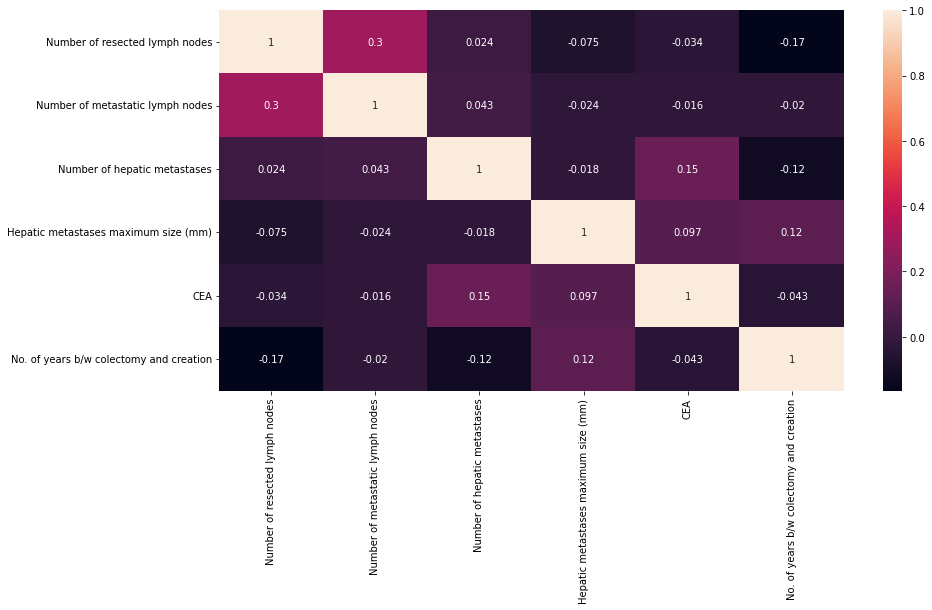

In [138]:
#After converting to strings, removing duplicate columns and unrealted features we get the follwing heatmAP
#We can see that the features are not much correlated to each other and hence no multi-collienarity

plt.figure(figsize = (14,7))
sns.heatmap(df.corr(), annot = True)

# ---------------------------------------------------------------------------------------------------------------

# Handling imbalance in the dataset i.e skewness and outliers

## Skewness of the features

skewness value of Number of resected lymph nodes is 4.778507321448451


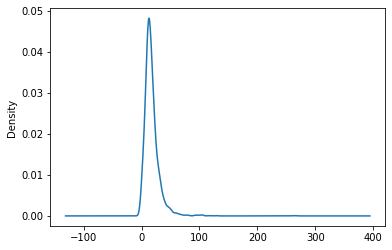

skewness value of Number of metastatic lymph nodes is 3.7725264099783993


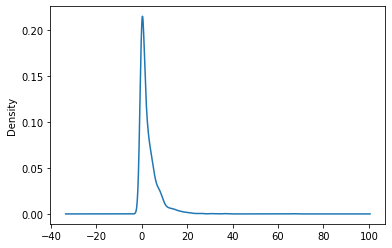

skewness value of Number of hepatic metastases is 8.580341601214824


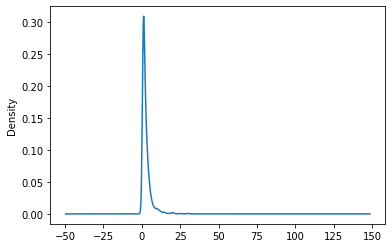

skewness value of Hepatic metastases maximum size (mm) is 5.510978282497288


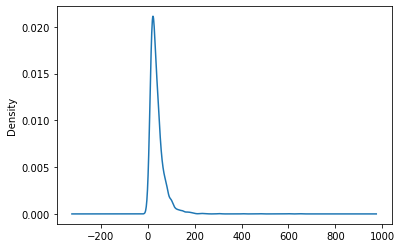

skewness value of CEA is 24.872775117650644


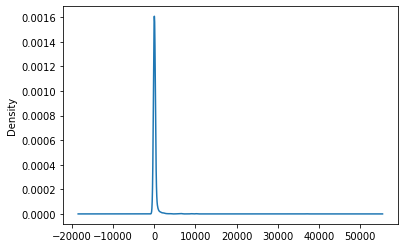

skewness value of No. of years b/w colectomy and creation is 0.8138339069595875


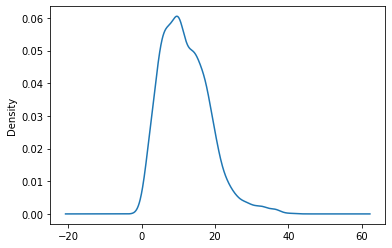

'\nbetween -0.5 & 0.5, the data are nearly symmetrical.\nbetween -1 & -0.5 (negative/left skewed) or between 0.5 & 1(positive/right skewed), the data are slightly skewed\nlower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed\n'

In [139]:
#we don't consider the outliers in "Age" since outliers in age such as 107 is faily acceptable
#Since the data is heavily skewed due to outliers, we'll handel the outliers first

for col in df.columns:
    if (df[col].dtype == 'float'):
        print(f'skewness value of {col} is {df[col].skew()}')
        df[col].plot.kde()
        plt.show()
'''
between -0.5 & 0.5, the data are nearly symmetrical.
between -1 & -0.5 (negative/left skewed) or between 0.5 & 1(positive/right skewed), the data are slightly skewed
lower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed
'''

## Handling outliers

### Quantile based flooring and capping

In [140]:
#Removing the outliers which are less than 20th percentile or greater than 80th percentile
#Since removing according to the traditional 25th and 75th precentile will result in huge loss of data 
#we increase the threshold precentile

def detect_outiers(df, variables):
    q1 = df[variables].quantile(0.20)
    q3 = df[variables].quantile(0.80)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    return lower, upper 

In [141]:
out_perct = {}

for col in df.columns:
    if (df[col].dtype == 'float'):
        lower, upper = detect_outiers(df, col)
        
        total_values = df[col].shape[0]
        outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        perc_of_outliers = outliers/total_values*100
        out_perct.update( {col : round(perc_of_outliers, 2)})
        
out_perct

{'CEA': 5.36,
 'Hepatic metastases maximum size (mm)': 2.11,
 'No. of years b/w colectomy and creation': 0.54,
 'Number of hepatic metastases': 3.84,
 'Number of metastatic lymph nodes': 1.88,
 'Number of resected lymph nodes': 1.43}

In [142]:
out_perct1 = {}

for col in df.columns:
    if (df[col].dtype == 'float'):
        lower, upper = detect_outiers(df, col)
        
        df = df[(df[col] > lower) & (df[col] < upper)]

In [143]:
df.shape

(872, 24)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


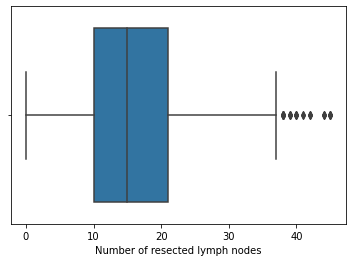

In [144]:
sns.boxplot(df['Number of resected lymph nodes'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


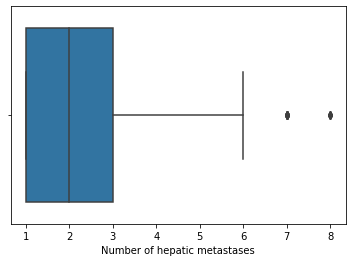

In [145]:
sns.boxplot(df['Number of hepatic metastases'])



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


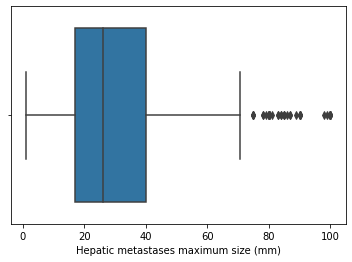

In [146]:
sns.boxplot(df['Hepatic metastases maximum size (mm)'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


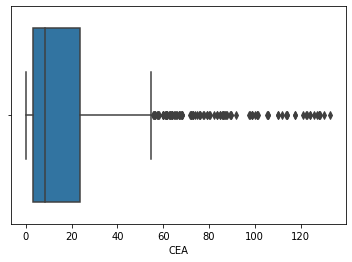

In [147]:
sns.boxplot(df['CEA'])

In [148]:
#Checking for skewness again after removing the majority of outliers
#We can see that the skewness is considerably reduced after outliers removal

for col in df.columns:
    if (df[col].dtype == 'float'):
        print(f'skewness of {col} is {df[col].skew()}')

skewness of Number of resected lymph nodes is 0.8377574160339242
skewness of Number of metastatic lymph nodes is 1.362994163143557
skewness of Number of hepatic metastases is 1.4656320655688029
skewness of Hepatic metastases maximum size (mm) is 1.2944414881151143
skewness of CEA is 2.0688970910966193
skewness of No. of years b/w colectomy and creation is 0.17537861036277624


### Transforming the data to further reduce skewness

In [149]:
#Applying log trasnformation to reduce skewness
#Since the skewness of 'Number of resected lymph nodes' is already in the acceptable range we ignore that

for col in df.columns:
    if (df[col].dtype == 'float') & (col != 'No. of years b/w colectomy and creation'):
        df[col] = np.log(df[col] + 1)
    

skewness of Number of metastatic lymph nodes is 0.3377436611678172


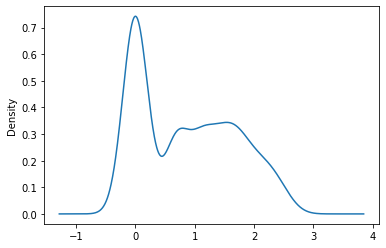

skewness of Number of hepatic metastases is 0.738260248894427


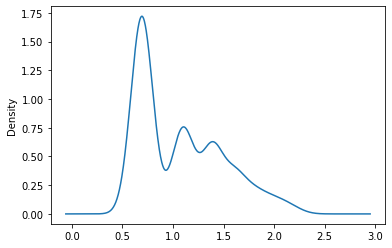

skewness of Hepatic metastases maximum size (mm) is -0.4502300147283876


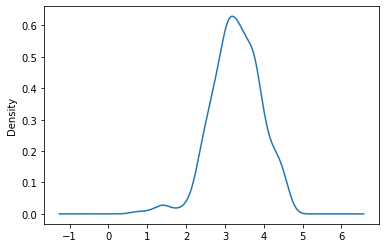

skewness of CEA is 0.3393845625436443


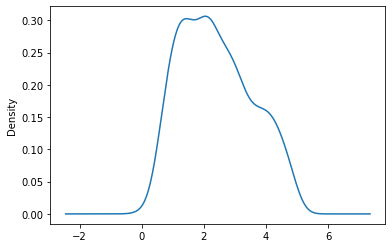

skewness of No. of years b/w colectomy and creation is 0.17537861036277624


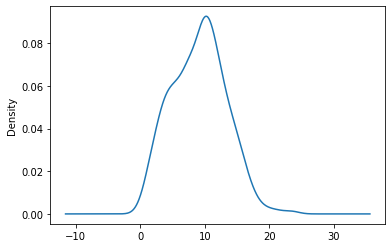

In [150]:
for col in df.columns:
    if (df[col].dtype == 'float') & (col != 'Number of resected lymph nodes'):
        print(f'skewness of {col} is {df[col].skew()}')
        df[col].plot.kde()
        plt.show()
        

# ---------------------------------------------------------------------------------------------------------------

## Handling missing values

In [151]:
df.isnull().sum()

Inclusion criteria                                                     0
Gender                                                                 1
Age category                                                           0
Did the patient have pre-colectomy therapy (radiotherapy excluded)     1
Did the patient have pre-colectomy radiotherapy                       11
Laparoscopic resection                                                 4
Tumor                                                                 89
Node                                                                   0
Metastasis                                                             2
Number of resected lymph nodes                                         0
Number of metastatic lymph nodes                                       0
Synchronicity of colorectal cancer                                     6
Number of hepatic metastases                                           0
Hepatic metastases maximum size (mm)               

In [152]:
df.replace(['ND','nan'], np.nan, inplace = True)

In [153]:
def median(col):
    df[col] = df[col].fillna(df[col].median())

def mode(columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0])

In [154]:
categorical_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
datetime_features = [feature for feature in df.columns if df[feature].dtypes == '<M8[ns]']


In [155]:
df.replace(['ND','nan'], np.nan, inplace = True)
mode(categorical_features)
mode(datetime_features)
df['Age category'] = df['Age category'].fillna(df['Age category'].mode()[0])

#### Analyzing distribution of data

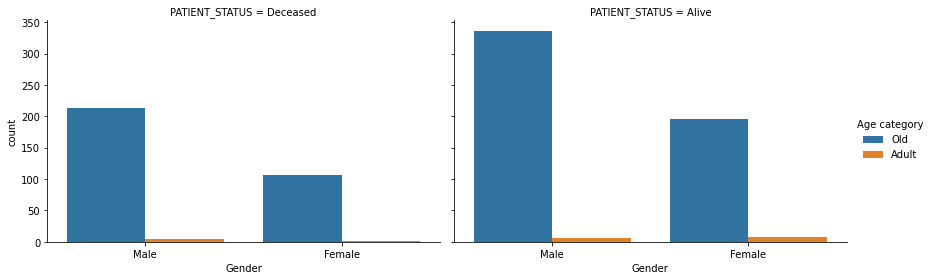

In [156]:
sns.catplot(x="Gender", hue="Age category", col="PATIENT_STATUS",
                data=df, kind="count",
                height=4, aspect=1.5)

# ---------------------------------------------------------------------------------------------------------------

# Feature scaling

In [157]:
numerical_features = [feature for feature in df.columns if (df[feature].dtypes == 'float') & (feature != 'No. of years b/w colectomy and creation')]

In [158]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])

# ---------------------------------------------------------------------------------------------------------------

## One hot encoding categorical features

In [159]:
final_df = pd.get_dummies(data = df, columns = categorical_features, drop_first = True)

In [160]:
final_df.columns

Index(['Number of resected lymph nodes', 'Number of metastatic lymph nodes',
       'Number of hepatic metastases', 'Hepatic metastases maximum size (mm)',
       'CEA', 'No. of years b/w colectomy and creation',
       'Inclusion criteria_Yes', 'Gender_Male', 'Age category_Old',
       'Did the patient have pre-colectomy therapy (radiotherapy excluded)_Yes',
       'Did the patient have pre-colectomy radiotherapy_Yes',
       'Laparoscopic resection_Yes', 'Tumor_T1', 'Tumor_T2', 'Tumor_T3',
       'Tumor_T4', 'Tumor_T4a', 'Node_N1', 'Node_N1a', 'Node_N1b', 'Node_N2',
       'Node_N2a', 'Metastasis_M1', 'Metastasis_M1b',
       'Synchronicity of colorectal cancer_Yes', 'Localization_Unilateral',
       'CT scan abdominal_Yes', 'CT scan chest_Yes', 'MRI_Yes', 'Pet CT_Yes',
       'Initial resectability_Yes',
       'Does the patient have concomitant extra-hepatic metastases_Yes',
       'PATIENT_STATUS_Deceased'],
      dtype='object')

# ---------------------------------------------------------------------------------------------------------------

# Model building

In [161]:
x = final_df.iloc[:,:-1]
y = final_df['PATIENT_STATUS_Deceased']

In [162]:
final_df.shape

(872, 33)

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 12, shuffle=True)

#### Function to plot confusion matrix

In [164]:
def plt_cm(cm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    return labels

# ---------------------------------------------------------------------------------------------------------------

# XGBoost

In [165]:
#using "roc-auc" accuracy metri since the target variable is imbalanced

In [166]:

#pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [167]:
classifier = XGBClassifier()

In [168]:
classifier.fit(X_train,y_train)

XGBClassifier()

In [169]:
y_pred = classifier.predict(X_test)         

In [170]:
accuracy_score(y_test, y_pred)

0.6972477064220184

In [171]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[115  22]
 [ 44  37]]


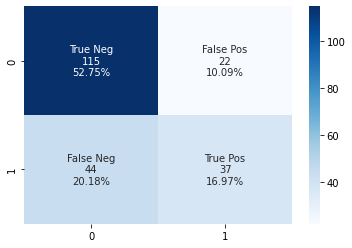

In [172]:
labels = plt_cm(cm)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [173]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.84      0.78       137
           1       0.63      0.46      0.53        81

    accuracy                           0.70       218
   macro avg       0.68      0.65      0.65       218
weighted avg       0.69      0.70      0.68       218



In [174]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Specificity = TN/(TN+FP)
Sensitivity = TP/(FN+TP)

print(f'Specificity is {Specificity}')
print(f'Sensitivity is {Sensitivity}')

Specificity is 0.8394160583941606
Sensitivity is 0.4567901234567901


### Hyperparameter tuning

In [175]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [176]:
from scipy.stats import randint
from scipy.stats import uniform

hyperparameter_grid = { 'n_estimators': [100,200,300,500,1000],
              'learning_rate': uniform.stats(0.01, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
              'colsample_bytree': uniform.stats(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4],
              'base_score':[0.25,0.5,0.75,1],
              'gamma':[0.5, 1, 1.5, 2, 5],
              'min_samples_split': [2,5,10,15,20],
              "bootstrap": [True, False],
              'min_samples_leaf':[1,2,5,10,15]
             }

In [177]:
random_cv = RandomizedSearchCV(estimator=classifier,
            param_distributions=hyperparameter_grid,
            cv=5,
            scoring = 'accuracy',n_jobs = -1,
            verbose = 5, random_state = 12)

In [178]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 7

RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'bootstrap': [True, False],
                                        'colsample_bytree': (array(0.95),
                                                             array(0.0675)),
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': (array(0.31),
                                                          array(0.03)),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [

In [179]:
random_cv.best_estimator_

XGBClassifier(base_score=0.75, bootstrap=False, colsample_bytree=array(0.95),
              gamma=1.5, learning_rate=array(0.03), min_child_weight=4,
              min_samples_leaf=2, min_samples_split=5, n_estimators=300)

In [180]:
classifier = random_cv.best_estimator_

In [181]:
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.75, bootstrap=False, colsample_bytree=array(0.95),
              gamma=1.5, learning_rate=array(0.03), min_child_weight=4,
              min_samples_leaf=2, min_samples_split=5, n_estimators=300)

In [182]:
y_pred = classifier.predict(X_test)         

In [183]:
accuracy_score(y_test, y_pred)

0.7110091743119266

In [184]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[114  23]
 [ 40  41]]


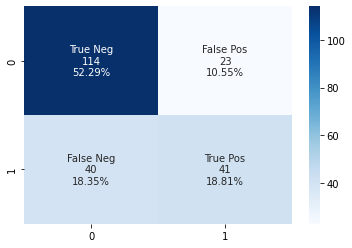

In [185]:
labels = plt_cm(cm)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [186]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       137
           1       0.64      0.51      0.57        81

    accuracy                           0.71       218
   macro avg       0.69      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218



In [187]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Specificity = TN/(TN+FP)
Sensitivity = TP/(FN+TP)

print(f'Specificity is {Specificity}')
print(f'Sensitivity is {Sensitivity}')

Specificity is 0.8321167883211679
Sensitivity is 0.5061728395061729


# ---------------------------------------------------------------------------------------------------------------

# Random forest

In [188]:
from sklearn.ensemble import RandomForestClassifier

In [189]:
classifier1 = RandomForestClassifier(random_state = 0)
classifier1.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [190]:
y_pred = classifier1.predict(X_test)  

In [191]:

accuracy_score(y_test, y_pred)

0.6788990825688074

In [192]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[118  19]
 [ 51  30]]


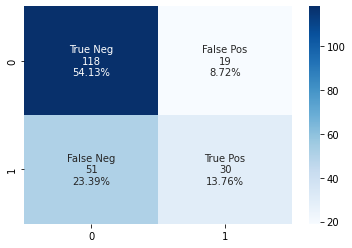

In [193]:
labels = plt_cm(cm)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [194]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       137
           1       0.61      0.37      0.46        81

    accuracy                           0.68       218
   macro avg       0.66      0.62      0.62       218
weighted avg       0.67      0.68      0.66       218



In [195]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Specificity = TN/(TN+FP)
Sensitivity = TP/(FN+TP)

print(f'Specificity is {Specificity}')
print(f'Sensitivity is {Sensitivity}')

Specificity is 0.8613138686131386
Sensitivity is 0.37037037037037035


### Hyperparameter tuning

In [196]:
grid_param = {'n_estimators' : [10, 100,500,800,1000],
              'max_features' : ['auto', 'sqrt', 'log2'],
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20,30,40],
              'min_samples_split': [2,5,10,15,20],
              'min_samples_leaf':[1,2,5,10,15],
              "bootstrap": [True, False]
             }
              

In [197]:
random_cv = RandomizedSearchCV(classifier, 
                         param_distributions = grid_param,
                         cv = 5,  
                         n_iter = 50, 
                         scoring = 'accuracy', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

In [198]:
random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, error_score=0,
                   estimator=XGBClassifier(base_score=0.75, bootstrap=False,
                                           colsample_bytree=array(0.95),
                                           gamma=1.5, learning_rate=array(0.03),
                                           min_child_weight=4,
                                           min_samples_leaf=2,
                                           min_samples_split=5,
                                           n_estimators=300),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
    

In [202]:
classifier1 = random_cv.best_estimator_
classifier1

XGBClassifier(base_score=0.75, bootstrap=False, colsample_bytree=array(0.95),
              gamma=1.5, learning_rate=array(0.03), max_features='sqrt',
              min_child_weight=4, min_samples_leaf=5, min_samples_split=10,
              n_estimators=500)

In [203]:
classifier1.fit(X_train, y_train)


XGBClassifier(base_score=0.75, bootstrap=False, colsample_bytree=array(0.95),
              gamma=1.5, learning_rate=array(0.03), max_features='sqrt',
              min_child_weight=4, min_samples_leaf=5, min_samples_split=10,
              n_estimators=500)

In [204]:
y_pred = classifier1.predict(X_test)
accuracy_score(y_test, y_pred)

0.7064220183486238

In [205]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[111  26]
 [ 38  43]]


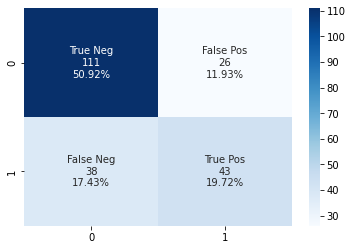

In [206]:
labels = plt_cm(cm)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [207]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78       137
           1       0.62      0.53      0.57        81

    accuracy                           0.71       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218



In [208]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Specificity = TN/(TN+FP)
Sensitivity = TP/(FN+TP)

print(f'Specificity is {Specificity}')
print(f'Sensitivity is {Sensitivity}')

Specificity is 0.8102189781021898
Sensitivity is 0.5308641975308642


# ---------------------------------------------------------------------------------------------------------------

## Naive Bayes

In [209]:
from sklearn.naive_bayes import BernoulliNB
b_clf = BernoulliNB()

In [210]:
b_clf.fit(X_train, y_train)

BernoulliNB()

In [211]:
y_pred_b = b_clf.predict(X_test)

In [212]:
accuracy_score(y_test, y_pred_b)


0.6926605504587156

In [213]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[111  26]
 [ 38  43]]


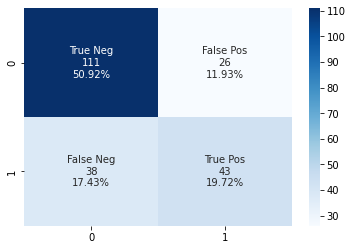

In [214]:
labels = plt_cm(cm)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [215]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78       137
           1       0.62      0.53      0.57        81

    accuracy                           0.71       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218



In [216]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Specificity = TN/(TN+FP)
Sensitivity = TP/(FN+TP)

print(f'Specificity is {Specificity}')
print(f'Sensitivity is {Sensitivity}')

Specificity is 0.8102189781021898
Sensitivity is 0.5308641975308642


# ---------------------------------------------------------------------------------------------------------------

In [218]:
!pip install nbconvert
!jupyter nbconvert --to html /content/Final - CWRK-Copy1 - 71.55%.ipynb


This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run nbconvert in place, overwriting the existing notebook (only 
    relevan